In [587]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, Subset
# import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")

In [588]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

No GPU available!


In [590]:
df = pd.read_csv('./data/2011-2018_50*50_all_features_grids.csv', dtype=float)

In [591]:
df

injection_vol_sum  injection_psi_sum  injection_depth_avg  \
0                   0.0                0.0                  0.0   
1                   0.0                0.0                  0.0   
2                   0.0                0.0                  0.0   
3                   0.0                0.0                  0.0   
4                   0.0                0.0                  0.0   
...                 ...                ...                  ...   
2495                0.0                0.0                  0.0   
2496          1966271.0            33600.0               2251.0   
2497                0.0                0.0                  0.0   
2498                0.0                0.0                  0.0   
2499           233380.0                0.0               1615.0   

      injection_under_basement_number  active_well_number  well_depth_avg  \
0                                 0.0                 1.0      650.000000   
1                                 0.0                 5.0      480.000000   
2                                 0.0                 0.0        0.000000   
3                                 0.0                 0.0        0.000000   
4                                 0.0                 1.0     1200.000000   
...                               ...                 ...             ...   
2495                              0.0                77.0     1686.610390   
2496                              7.0                24.0     1883.750000   
2497                              0.0                64.0     1871.421875   
2498                              0.0               101.0     1508.267327   
2499                              4.0                33.0     1592.727273   

      well_under_basement_number  depth_to_basement_avg  hf_number  \
0                            1.0              91.628871        0.0   
1                            5.0              87.613036        0.0   
2                            0.0             122.520465        0.0   
3                            0.0             106.241226        0.0   
4                            1.0             122.269095        0.0   
...                          ...                    ...        ...   
2495                        77.0               0.000000        0.0   
2496                        24.0               0.000000        0.0   
2497                        64.0               0.000000        0.0   
2498                       101.0               0.000000        0.0   
2499                        33.0               0.000000        0.0   

      hf_base_water_volume_sum  hf_base_nowater_volume_sum  \
0                          0.0                         0.0   
1                          0.0                         0.0   
2                          0.0                         0.0   
3                          0.0                         0.0   
4                          0.0                         0.0   
...                        ...                         ...   
2495                       0.0                         0.0   
2496                       0.0                         0.0   
2497                       0.0                         0.0   
2498                       0.0                         0.0   
2499                       0.0                         0.0   

      earthquake_occurence  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
...                    ...  
2495                   0.0  
2496                   0.0  
2497                   0.0  
2498                   0.0  
2499                   0.0  

[2500 rows x 12 columns]

In [592]:
df.rename(columns = {"earthquake_occurence":"class"}, inplace=True)
df['class'].value_counts()

0.0    1570
1.0     930
Name: class, dtype: int64

In [593]:
labels = df['class']

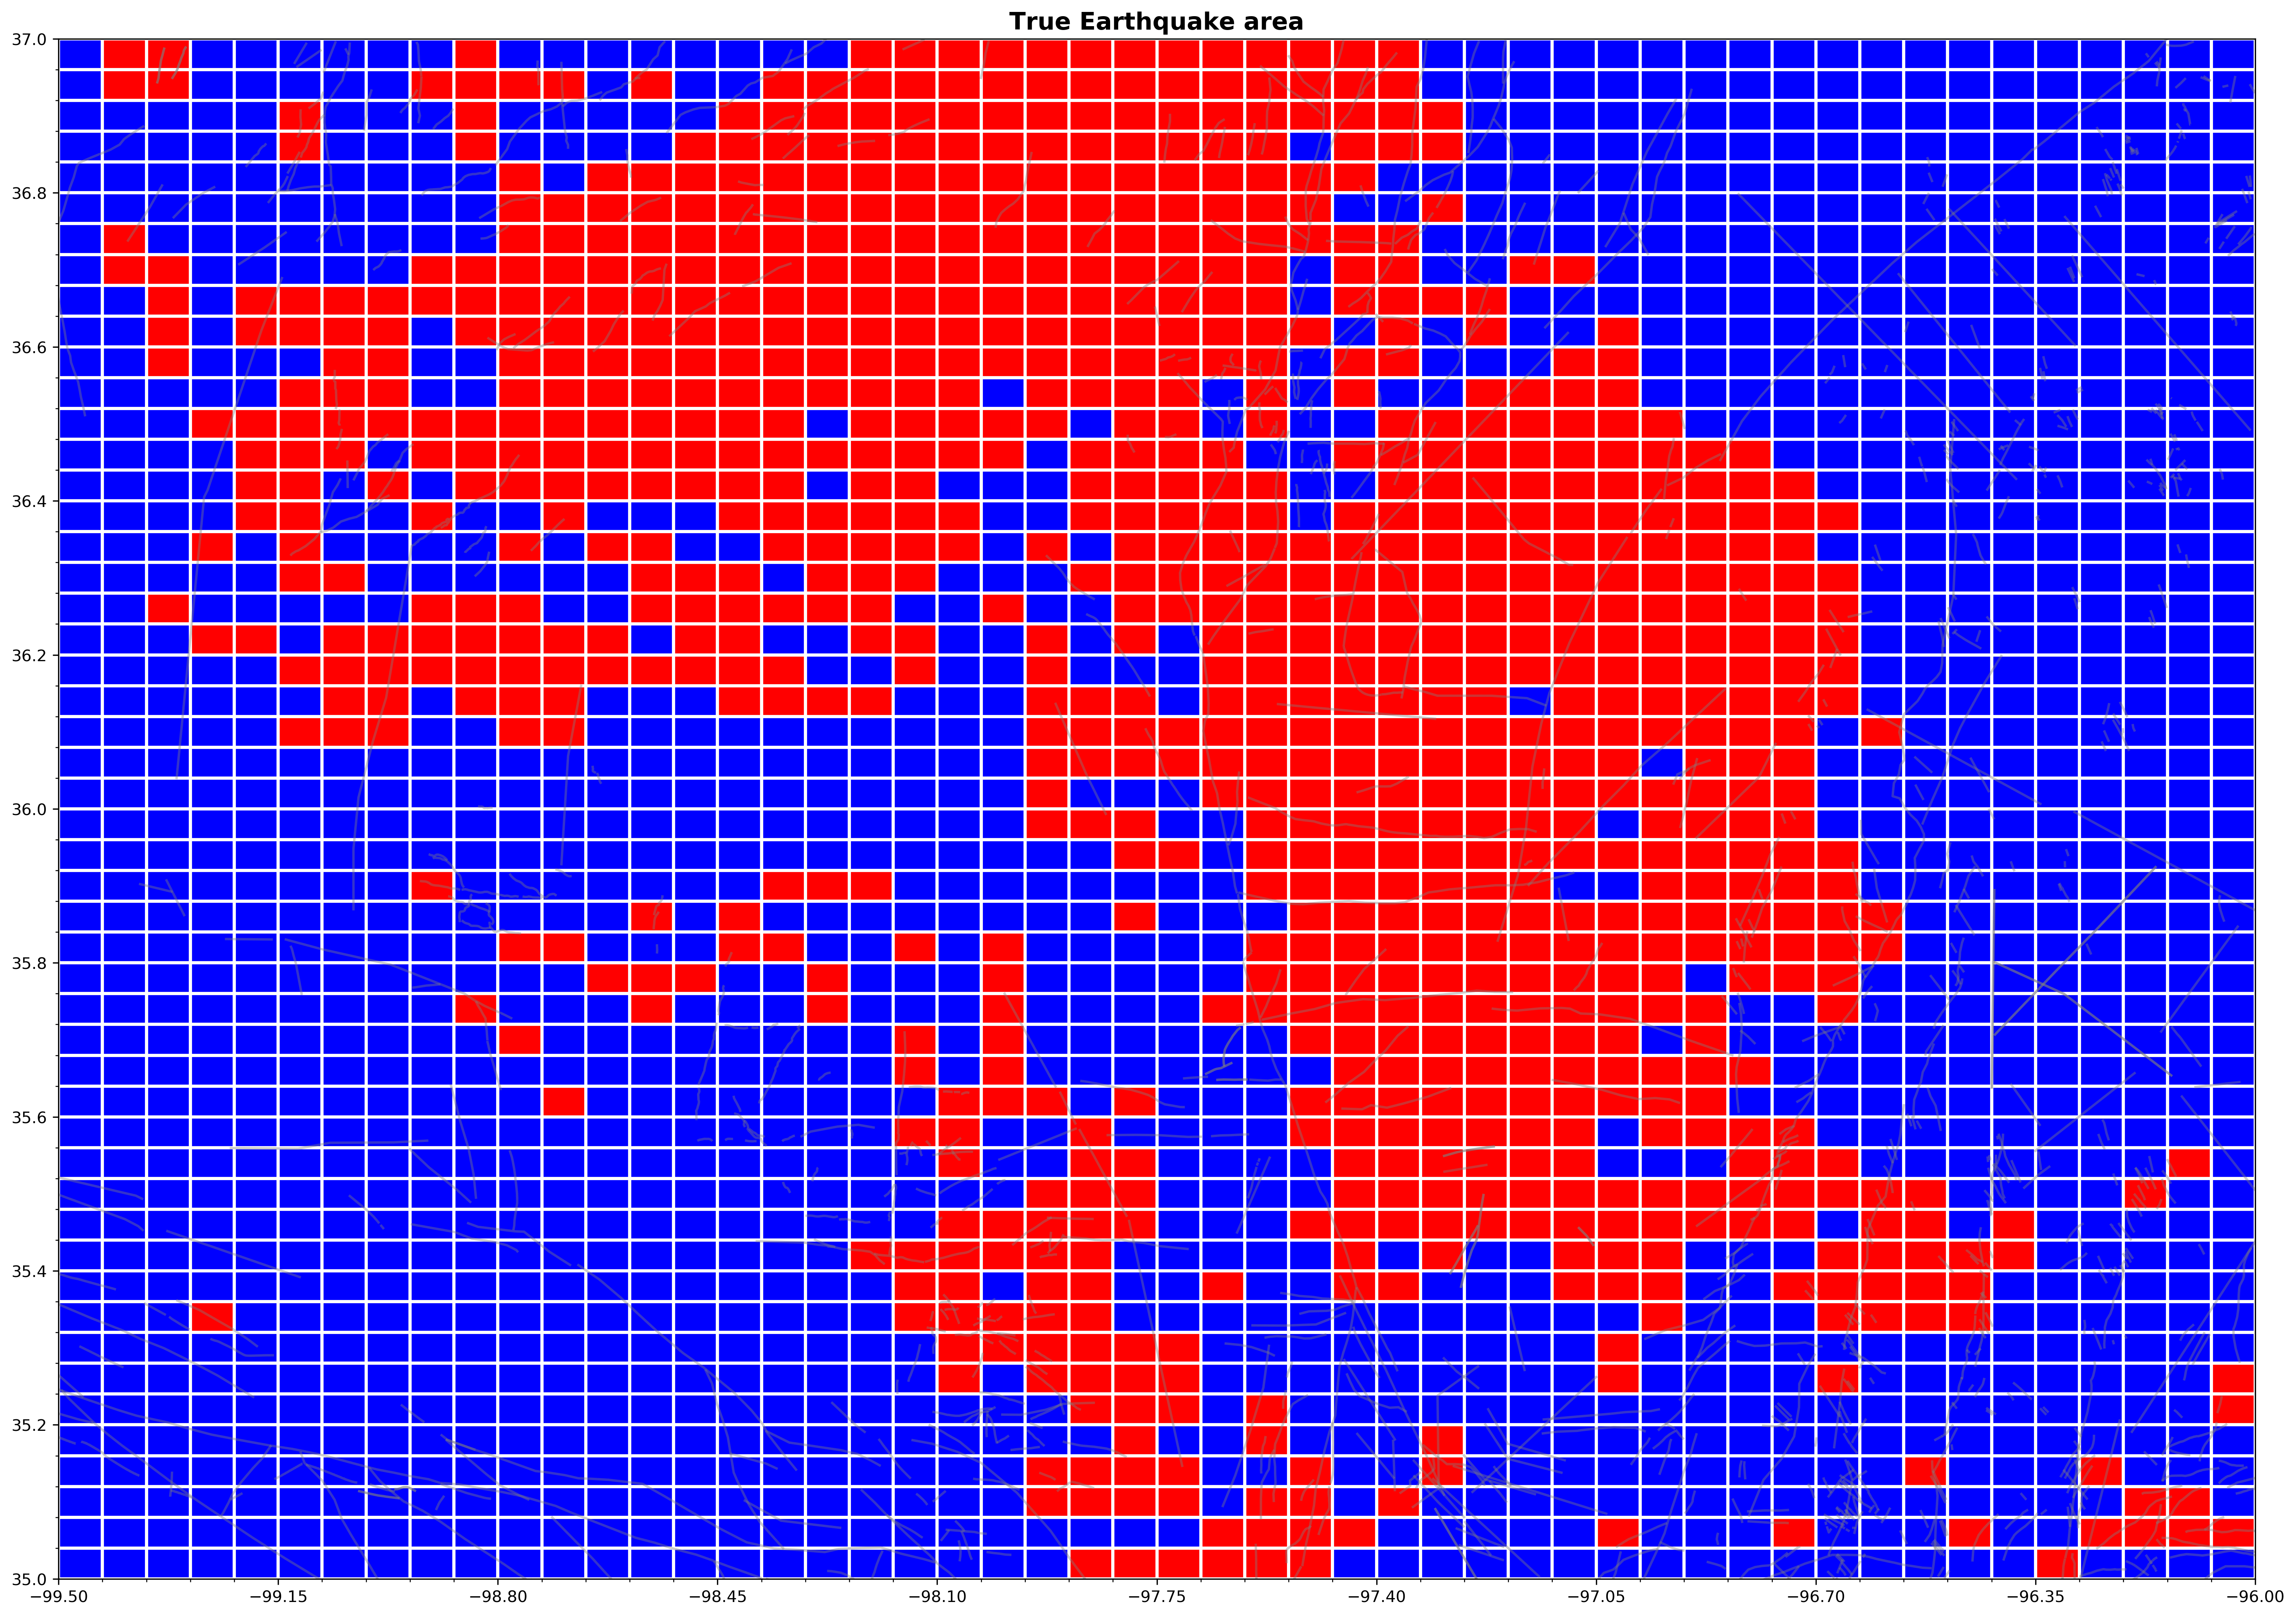

In [594]:
m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1
# m, n = (41, 41)
x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,1,1)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='grey')

# 设置地图范围
lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x


plot_list = labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1

minor_x_ticks=np.linspace(-99.5,-96,m)
major_x_ticks=np.linspace(-99.5,-96,int((m-1)/5+1))
minor_y_ticks=np.linspace(35,37,n)
major_y_ticks=np.linspace(35,37,int((n-1)/5+1))
ax1.set_xticks(major_x_ticks)
ax1.set_yticks(major_y_ticks)
ax1.set_xticks(minor_x_ticks, minor=True)
ax1.set_yticks(minor_y_ticks, minor=True)
ax1.grid(color='w', linestyle='-', linewidth=2, which='major')
ax1.grid(color='w', linestyle='-', linewidth=2, which='minor')
    
ax1.set_xlim(-99.5, -96)
ax1.set_ylim(35, 37)
ax1.set_title('True Earthquake area', fontsize=15,fontweight='bold')

# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.tight_layout()
plt.show()

# stepwise regression

In [596]:
## creating function to get model statistics
def get_stats():
    x = df[x_columns]
    y = df['class']
    
    mean_value = np.mean(x, axis=0)
    std_value = np.std(x, axis=0)

    feature_number = len(x_columns)
    # X_train
    for i in range(0, feature_number):
        feature_name = x_columns[i]
        x[feature_name]= (x[feature_name] - mean_value[feature_name]) / std_value[feature_name]

    results = sm.Logit(y, x).fit()
    print(results.summary())
    
def checkVIF_new(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    df['c'] = 1
    name = df.columns
    x = np.matrix(df)
    VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
    VIF = pd.DataFrame({'feature':name,"VIF":VIF_list})
    VIF = VIF[VIF.feature != 'c']
    max_VIF = max(VIF_list)
    print(VIF)

def remove_feature(feature):
    x_columns.remove(feature)
    if len(x_columns) > 0:
        get_stats()
        checkVIF_new(df[x_columns])

In [606]:
all_features = df.columns.tolist()[:-1]
all_features

['injection_vol_sum',
 'injection_psi_sum',
 'injection_depth_avg',
 'injection_under_basement_number',
 'active_well_number',
 'well_depth_avg',
 'well_under_basement_number',
 'depth_to_basement_avg',
 'hf_number',
 'hf_base_water_volume_sum',
 'hf_base_nowater_volume_sum']

In [607]:
x_columns = []
x_columns

[]

In [608]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  hf_base_nowater_volume_sum
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2499
Method:                           MLE   Df Model:                            0
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                -0.05020
Time:                        23:02:58   Log-Likelihood:                -1732.9
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                       nan
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_nowater_volume_sum    

In [609]:
remove_feature('hf_base_nowater_volume_sum')

In [610]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  hf_base_water_volume_sum
Optimization terminated successfully.
         Current function value: 0.690636
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2499
Method:                           MLE   Df Model:                            0
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                -0.04640
Time:                        23:02:59   Log-Likelihood:                -1726.6
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                       nan
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
hf_base_water_volume_sum     0.1499 

In [611]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  hf_number
Optimization terminated successfully.
         Current function value: 0.667301
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2498
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                -0.01104
Time:                        23:03:00   Log-Likelihood:                -1668.3
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
hf_base_water_volume_sum    -0.5193      0.083     

In [612]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  depth_to_basement_avg
Optimization terminated successfully.
         Current function value: 0.648326
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2497
Method:                           MLE   Df Model:                            2
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                 0.01771
Time:                        23:03:07   Log-Likelihood:                -1620.8
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                 2.052e-13
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
hf_base_water_volume_sum    -0.4518    

In [613]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  well_under_basement_number
Optimization terminated successfully.
         Current function value: 0.646464
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2496
Method:                           MLE   Df Model:                            3
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                 0.02053
Time:                        23:03:10   Log-Likelihood:                -1616.2
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                 1.303e-14
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      

In [614]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  well_depth_avg
Optimization terminated successfully.
         Current function value: 0.639345
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2495
Method:                           MLE   Df Model:                            4
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                 0.03131
Time:                        23:03:20   Log-Likelihood:                -1598.4
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                 1.920e-21
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      -0.5148     

In [615]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  active_well_number
Optimization terminated successfully.
         Current function value: 0.639276
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2494
Method:                           MLE   Df Model:                            5
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                 0.03142
Time:                        23:03:27   Log-Likelihood:                -1598.2
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                 8.865e-21
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      -0.5152 

In [616]:
remove_feature('well_under_basement_number')

Optimization terminated successfully.
         Current function value: 0.639277
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2495
Method:                           MLE   Df Model:                            4
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                 0.03141
Time:                        23:03:57   Log-Likelihood:                -1598.2
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                 1.626e-21
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
hf_base_water_volume_sum    -0.5152      0.084     -6.117      0.000      -0.680

In [617]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_under_basement_number
Optimization terminated successfully.
         Current function value: 0.637593
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2494
Method:                           MLE   Df Model:                            5
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                 0.03397
Time:                        23:04:00   Log-Likelihood:                -1594.0
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                 1.479e-22
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_v

In [618]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_depth_avg
Optimization terminated successfully.
         Current function value: 0.626051
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2493
Method:                           MLE   Df Model:                            6
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                 0.05146
Time:                        23:04:08   Log-Likelihood:                -1565.1
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                 4.947e-34
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum   

In [619]:
remove_feature('active_well_number')

Optimization terminated successfully.
         Current function value: 0.626624
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2494
Method:                           MLE   Df Model:                            5
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                 0.05059
Time:                        23:04:36   Log-Likelihood:                -1566.6
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                 3.280e-34
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum           -0.4960      0.086     -5.789  

In [620]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_psi_sum
Optimization terminated successfully.
         Current function value: 0.626359
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2493
Method:                           MLE   Df Model:                            6
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                 0.05099
Time:                        23:04:44   Log-Likelihood:                -1565.9
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                 1.051e-33
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum     

In [621]:
remove_feature('injection_psi_sum')

Optimization terminated successfully.
         Current function value: 0.626624
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2494
Method:                           MLE   Df Model:                            5
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                 0.05059
Time:                        23:04:52   Log-Likelihood:                -1566.6
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                 3.280e-34
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum           -0.4960      0.086     -5.789  

In [622]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_vol_sum
Optimization terminated successfully.
         Current function value: 0.625235
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 2500
Model:                          Logit   Df Residuals:                     2493
Method:                           MLE   Df Model:                            6
Date:                Tue, 10 Aug 2021   Pseudo R-squ.:                 0.05269
Time:                        23:04:59   Log-Likelihood:                -1563.1
converged:                       True   LL-Null:                       -1650.0
Covariance Type:            nonrobust   LLR p-value:                 6.742e-35
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum     

In [32]:
# def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
#     initial_features = data.columns.tolist()
#     best_features = []
#     while (len(initial_features)>0):
#         remaining_features = list(set(initial_features)-set(best_features))
#         new_pval = pd.Series(index=remaining_features)
#         for new_column in remaining_features:
#             model = sm.Logit(target, sm.add_constant(data[best_features+[new_column]])).fit()
#             new_pval[new_column] = model.pvalues[new_column]
#         min_p_value = new_pval.min()
#         if(min_p_value<SL_in):
#             best_features.append(new_pval.idxmin())
#             while(len(best_features)>0):
#                 best_features_with_constant = sm.add_constant(data[best_features])
#                 p_values = sm.Logit(target, best_features_with_constant).fit().pvalues[1:]
#                 max_p_value = p_values.max()
#                 if(max_p_value >= SL_out):
#                     excluded_feature = p_values.idxmax()
#                     best_features.remove(excluded_feature)
#                 else:
#                     break 
#         else:
#             break
#     return best_features

In [ ]:
# x_columns_bi = stepwise_selection(df[x_columns],df['class'])

In [624]:
x_columns

['hf_base_water_volume_sum',
 'hf_number',
 'depth_to_basement_avg',
 'well_depth_avg',
 'injection_under_basement_number',
 'injection_depth_avg',
 'injection_vol_sum']

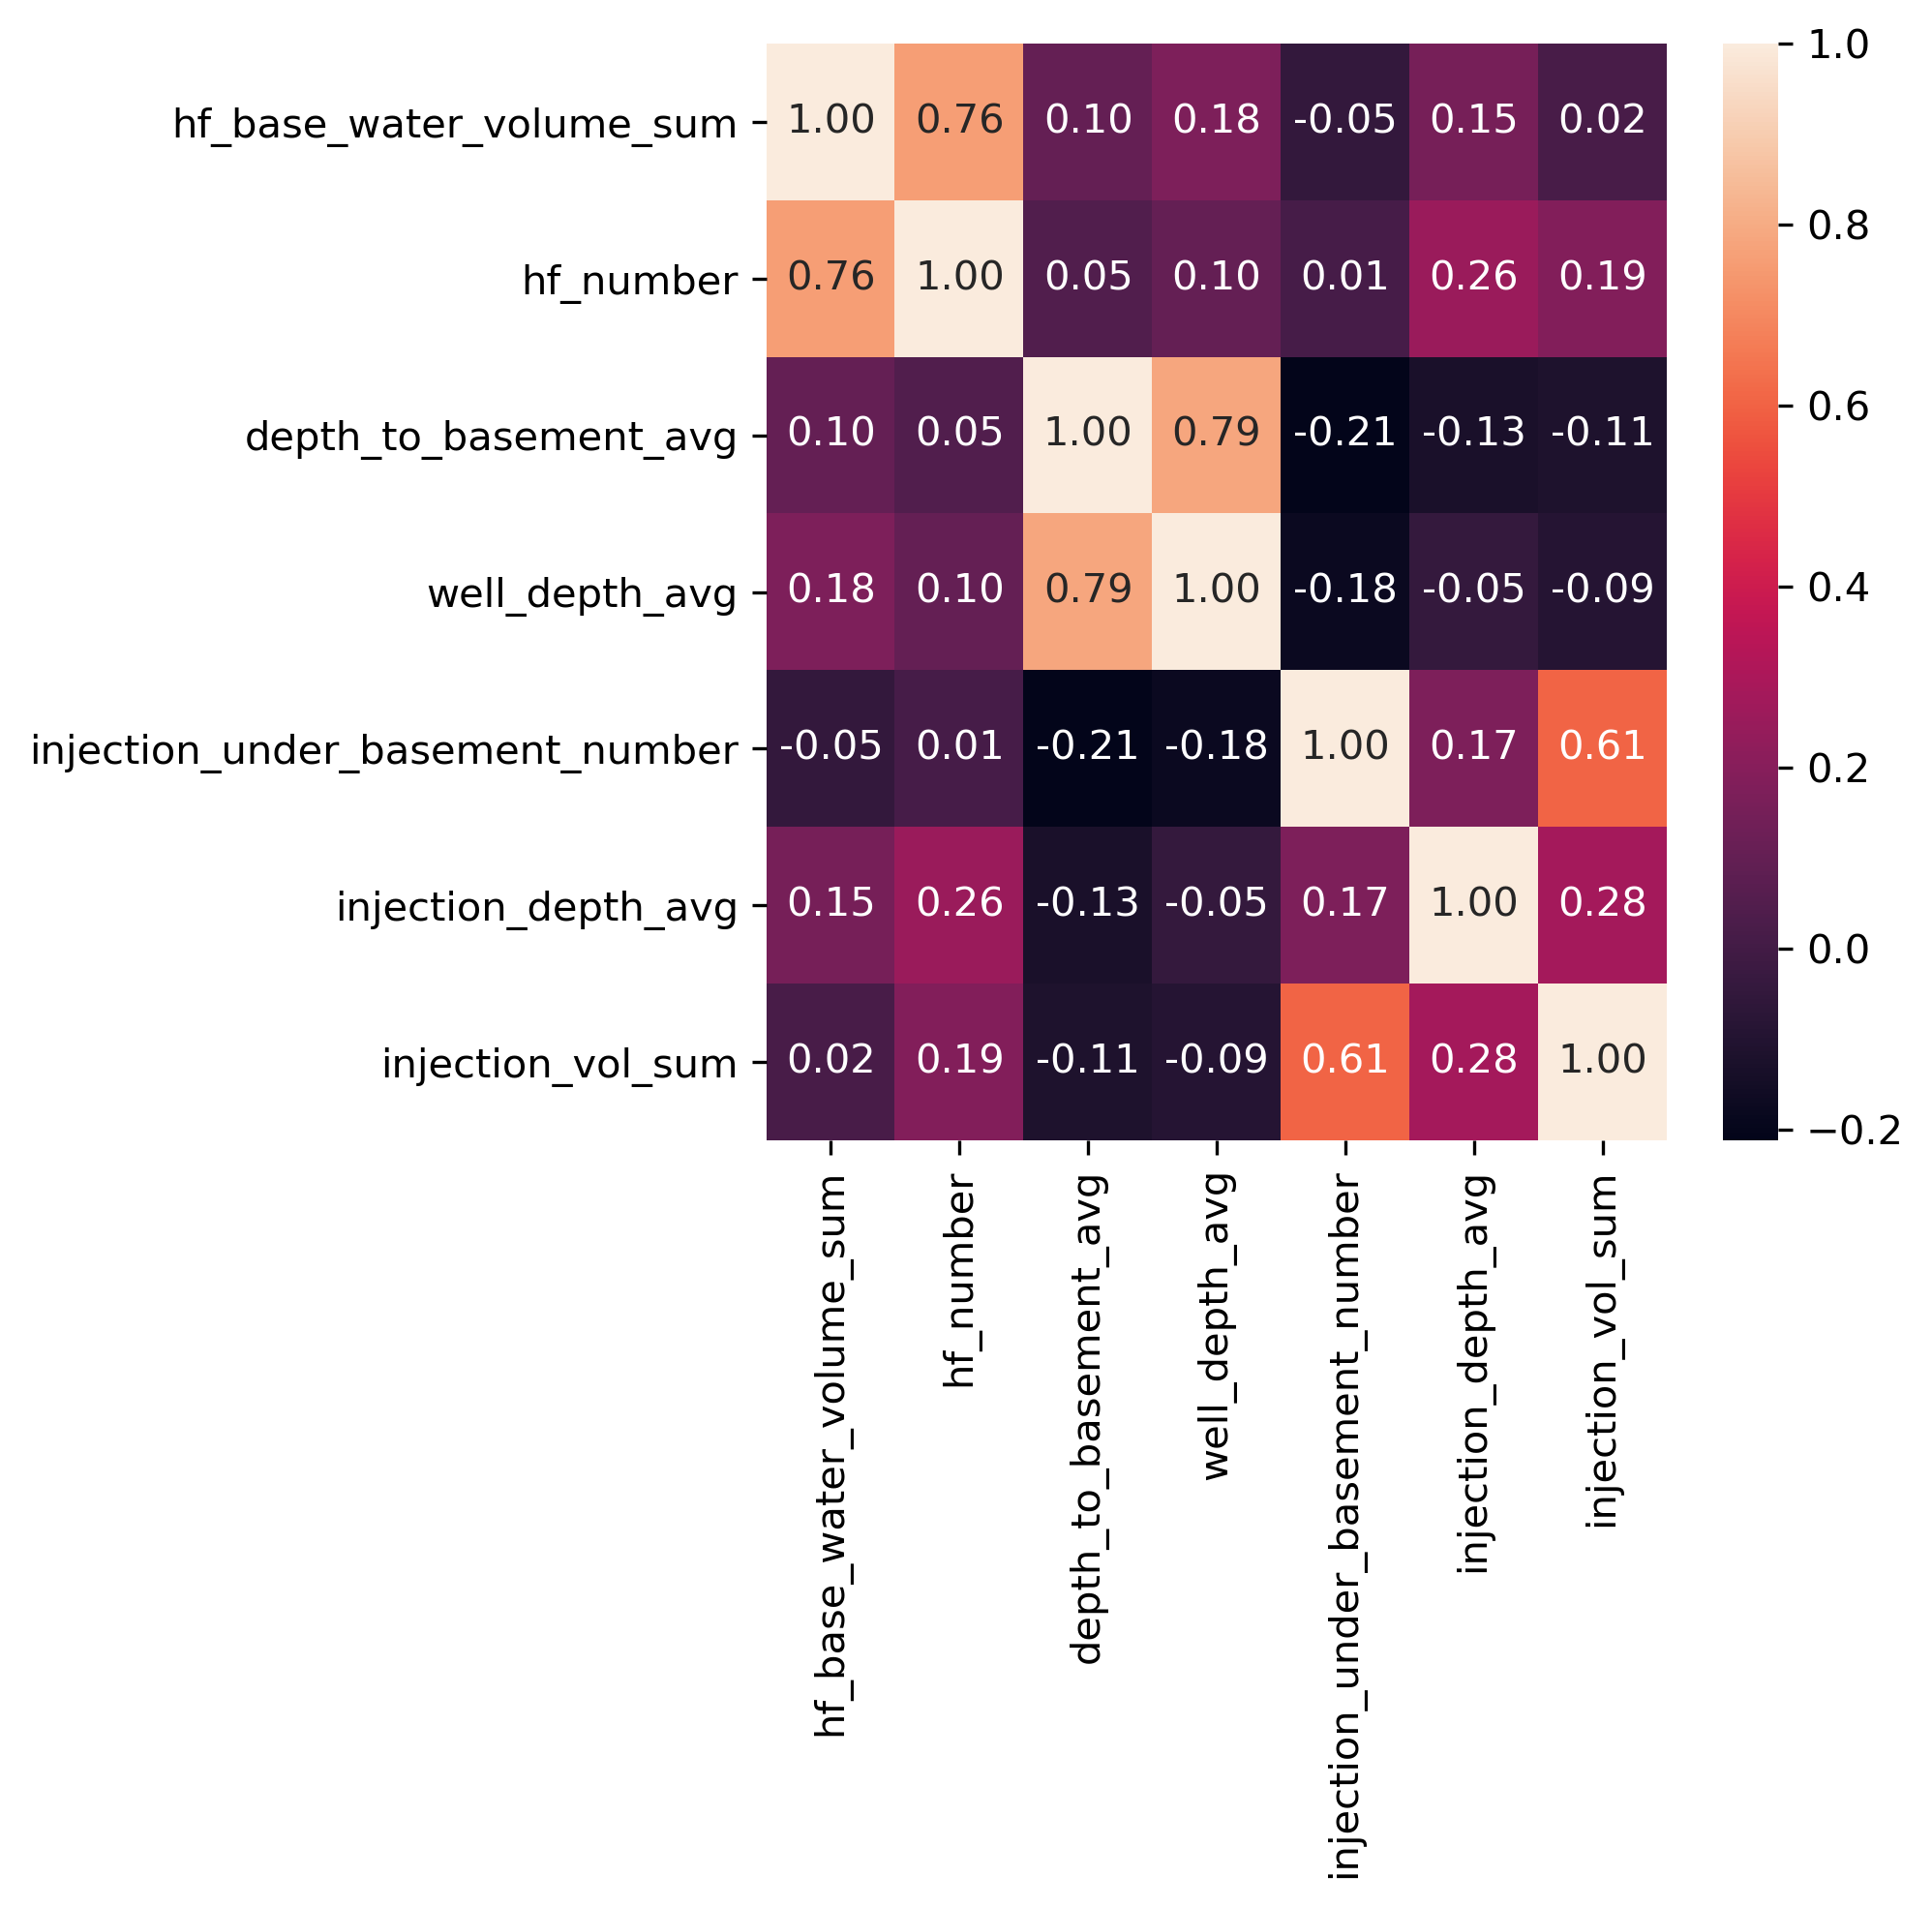

In [626]:
import seaborn as sns
# data=data_df
# # 相关性计算
dcorr = df[x_columns].corr()
plt.figure(figsize=(5, 5),dpi=300)
fig = sns.heatmap(data=dcorr, annot=True, fmt=".2f")

heat_fig = fig.get_figure()
heat_fig.savefig('./heatmap.png', dpi = 100)

In [627]:
#特征features
X = df[x_columns].values
#标签labels
Y = df['class'].values

X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8, random_state=42)

mean_value = np.mean(X_train, axis=0)
std_value = np.std(X_train, axis=0)

feature_number = len(x_columns)
# X_train
for i in range(0, feature_number):
    X_train[:,i] = (X_train[:,i] - mean_value[i]) / std_value[i]
    
for i in range(0, feature_number):
    X_test[:,i] = (X_test[:,i] - mean_value[i]) / std_value[i]

#输出数据大小
print('原始数据特征：',X.shape,
     '训练数据特征：',X_train.shape,
      '测试数据特征',X_test.shape)

print('原始数据标签：',Y.shape,
     '训练数据标签：',y_train.shape,
      '测试数据标签',y_test.shape)

feature_number = len(x_columns)

#将训练数据特征转换成二维数组X行*1列
X_train=X_train.reshape(-1,feature_number)
#将测试数据特征转换成二维数组X行*1列
X_test=X_test.reshape(-1,feature_number)


#第一步：创建模型：逻辑回归
model=LogisticRegression()
#第二步：训练模型
model.fit(X_train,y_train)

#第三步: 评估模型：准确率
model.score(X_test,y_test)

原始数据特征： (2500, 7) 训练数据特征： (2000, 7) 测试数据特征 (500, 7)
原始数据标签： (2500,) 训练数据标签： (2000,) 测试数据标签 (500,)


0.696

In [628]:
model.coef_[0]

array([-0.27711562,  0.54191228, -1.20096809,  0.73282643, -0.57458566,
        0.35603819,  0.26544649])

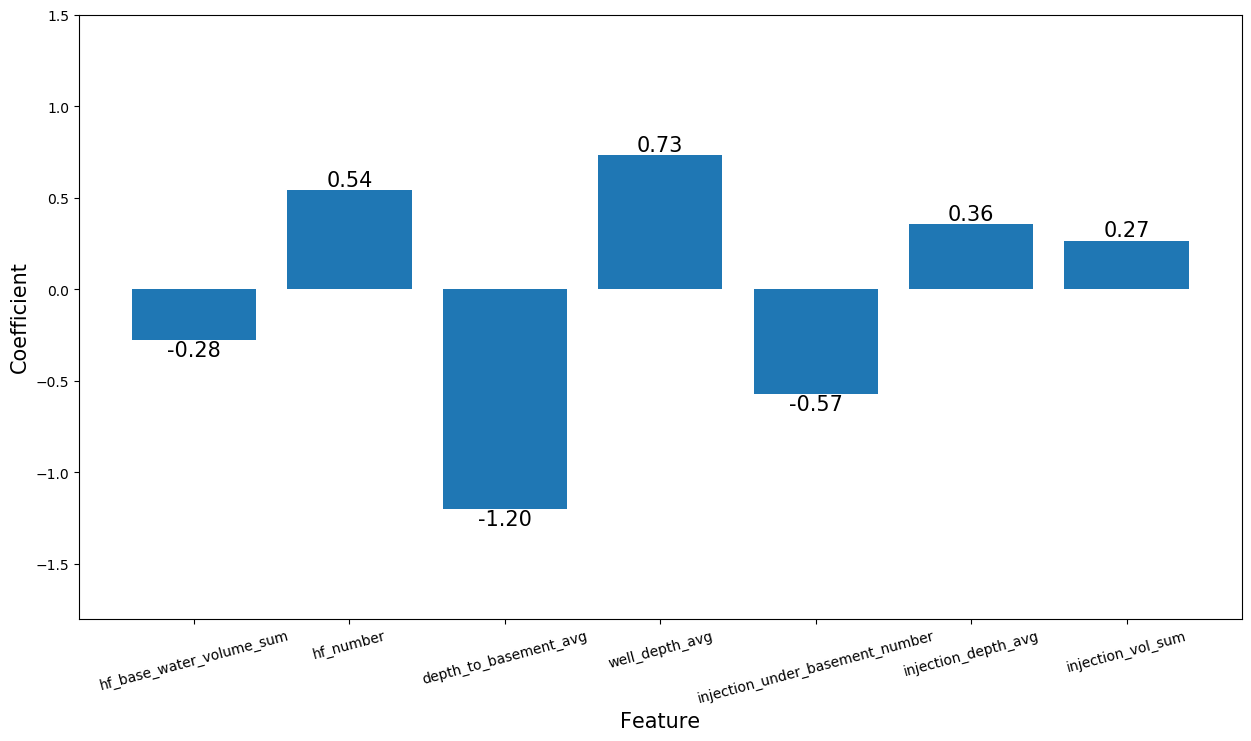

In [629]:
X = x_columns
Y = model.coef_[0]
fig = plt.figure(figsize=(15, 8), dpi=100)
plt.bar(X,Y)

for x,y in zip(X,Y):
    if y > 0:
        plt.text(x,y,'%.2f' %y, ha='center',va='bottom', fontsize=15)
    else:
        plt.text(x,y,'%.2f' %y, ha='center',va='top', fontsize=15)

plt.xlabel("Feature", fontsize=15)
plt.ylabel("Coefficient", fontsize=15)
# plt.title("Coefficients in Model", fontsize=18)
plt.xticks(rotation=15) # 倾斜70度
plt.ylim(-1.8, 1.5)
plt.show()

In [630]:
# 测试整个数据集
from sklearn.linear_model import LogisticRegression

test_labels = df['class'].values
test_features = df[x_columns].values

feature_number = len(x_columns)
for i in range(0, feature_number):
    test_features[:,i] = (test_features[:,i] - mean_value[i]) / std_value[i]
    
out_classes = model.predict(test_features)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.702


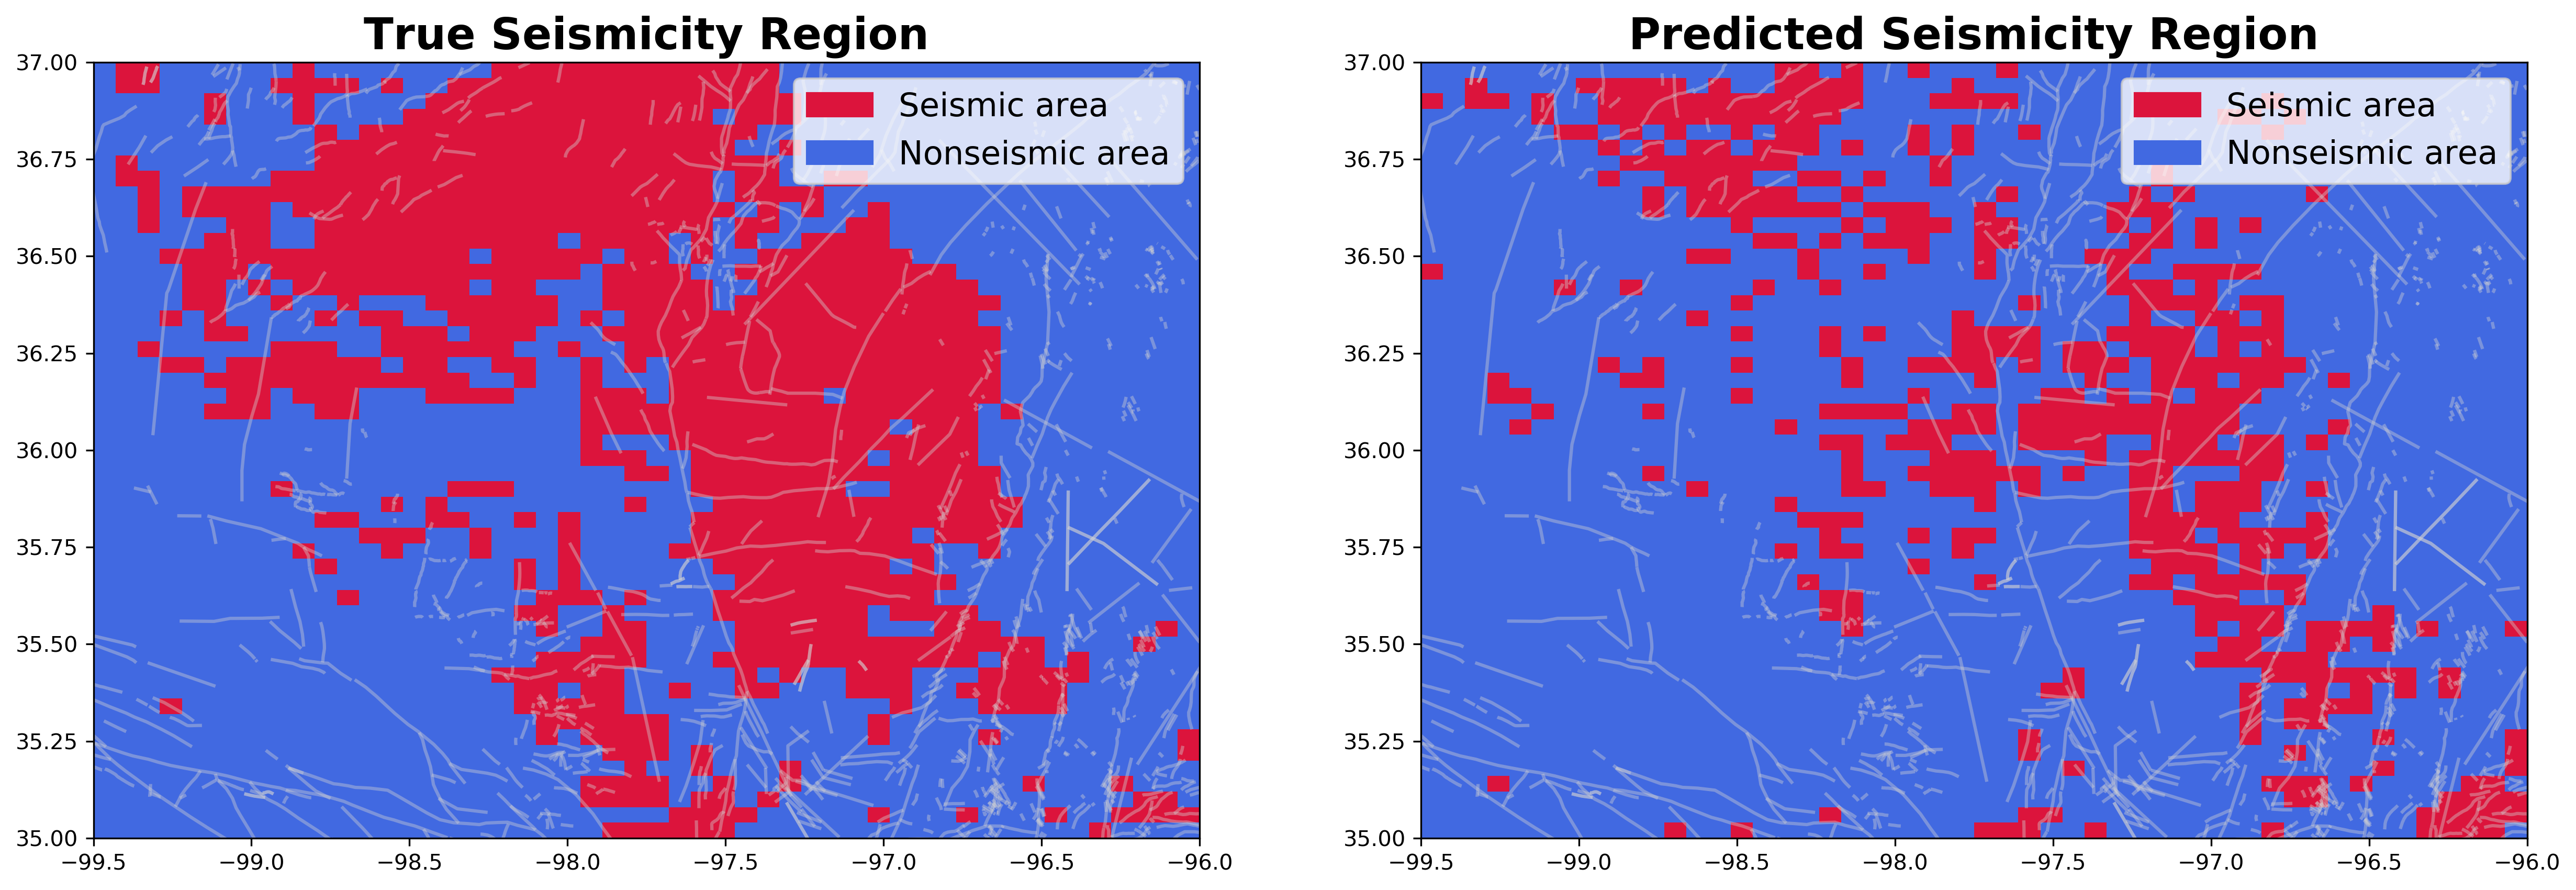

In [631]:
import matplotlib.patches as mpatches

m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1

x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='lightgrey')
oklahoma_map.plot(ax=ax2, alpha=0.4,color='lightgrey')

# 设置地图范围
lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x


plot_list = test_labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

plot_list = out_classes
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

ax1.set_xlim(-99.5, -96)
ax1.set_ylim(35, 37)
ax2.set_xlim(-99.5, -96)
ax2.set_ylim(35, 37)
ax1.set_title('True Seismicity Region', fontsize=20,fontweight='bold')
ax2.set_title('Predicted Seismicity Region', fontsize=20,fontweight='bold')


red_patch = mpatches.Patch(color='crimson', label='Seismic area')
blue_patch = mpatches.Patch(color='royalblue', label='Nonseismic area')
ax1.legend(handles=[red_patch, blue_patch], fontsize=15)
ax2.legend(handles=[red_patch, blue_patch], fontsize=15)
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()

# network construction

In [632]:
x_columns

['hf_base_water_volume_sum',
 'hf_number',
 'depth_to_basement_avg',
 'well_depth_avg',
 'injection_under_basement_number',
 'injection_depth_avg',
 'injection_vol_sum']

In [633]:
features = df[x_columns]
target = df['class']

In [634]:
# feature_names = df.columns.tolist()[:-1]

In [635]:
feature_names = features.columns.tolist()
print(feature_names)

['hf_base_water_volume_sum', 'hf_number', 'depth_to_basement_avg', 'well_depth_avg', 'injection_under_basement_number', 'injection_depth_avg', 'injection_vol_sum']


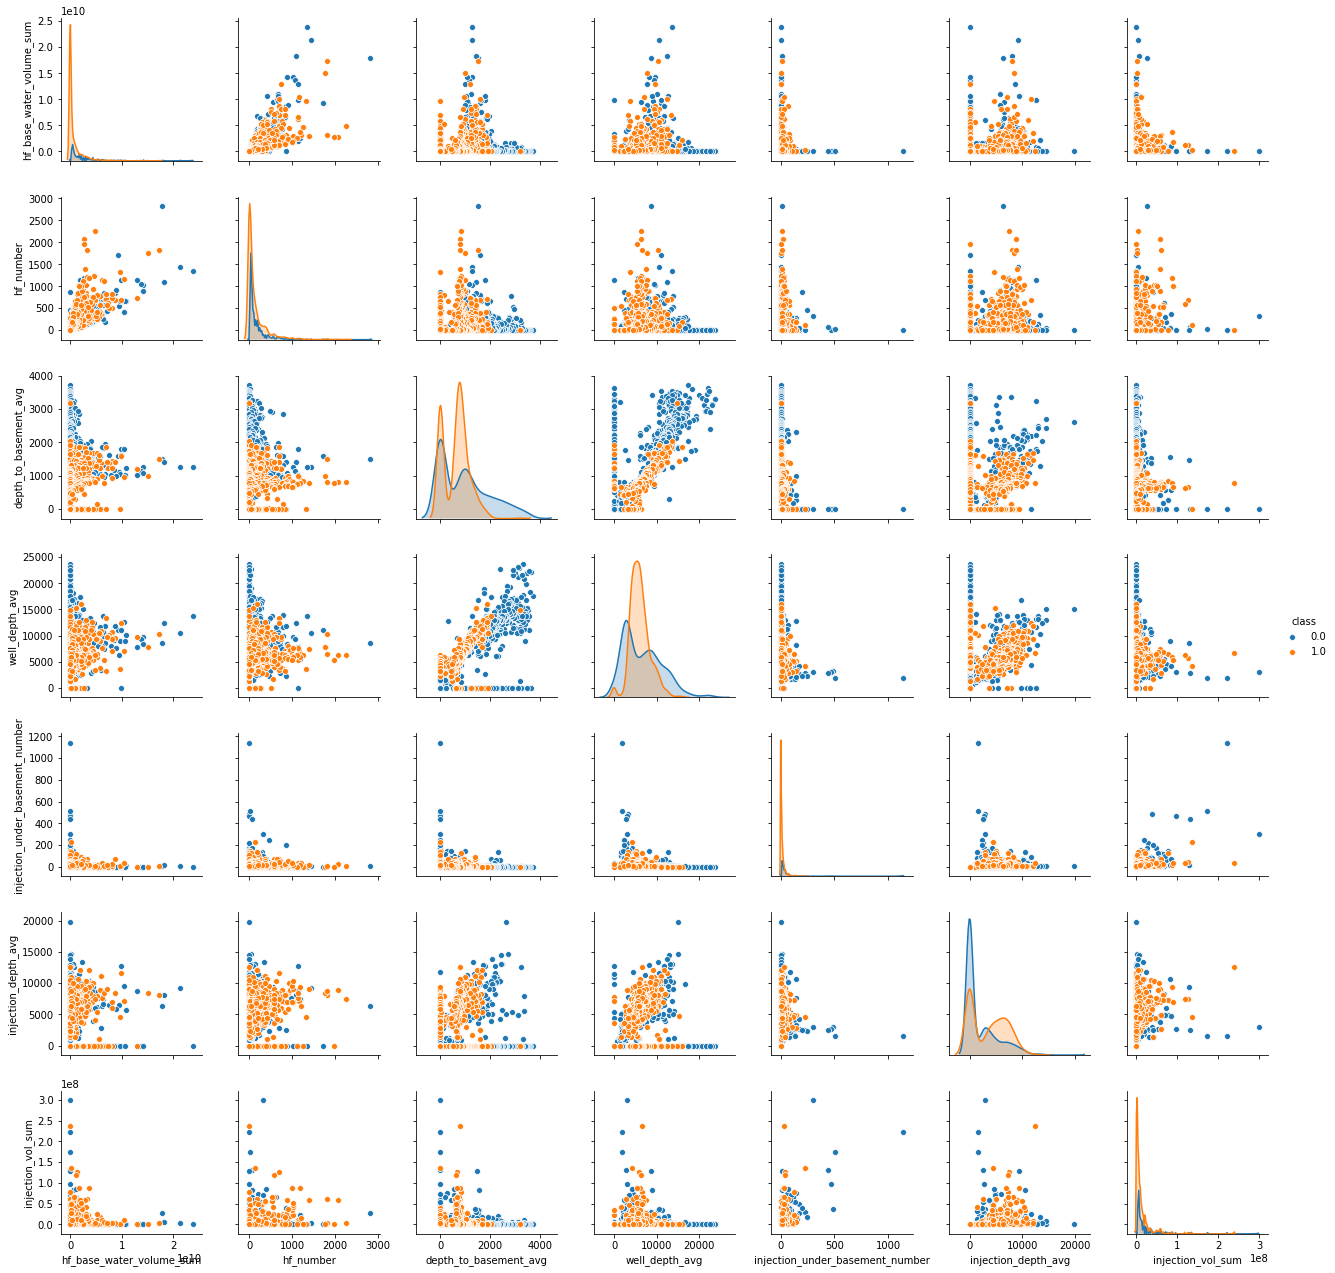

In [636]:
import matplotlib.pyplot as plt
import seaborn as sns  # seaborn作为matplotlib的补充，导入后会覆盖matplotlib的默认作图风格

sns.pairplot(df, hue='class', vars=feature_names)  # hue : 使用指定变量为分类变量画图；vars : 与data使用，否则使用data的全部变量
plt.show()  # 仍然使用matplotlib的显示函数

In [637]:
features

hf_base_water_volume_sum  hf_number  depth_to_basement_avg  \
0                          0.0        0.0              91.628871   
1                          0.0        0.0              87.613036   
2                          0.0        0.0             122.520465   
3                          0.0        0.0             106.241226   
4                          0.0        0.0             122.269095   
...                        ...        ...                    ...   
2495                       0.0        0.0               0.000000   
2496                       0.0        0.0               0.000000   
2497                       0.0        0.0               0.000000   
2498                       0.0        0.0               0.000000   
2499                       0.0        0.0               0.000000   

      well_depth_avg  injection_under_basement_number  injection_depth_avg  \
0         650.000000                              0.0                  0.0   
1         480.000000                              0.0                  0.0   
2           0.000000                              0.0                  0.0   
3           0.000000                              0.0                  0.0   
4        1200.000000                              0.0                  0.0   
...              ...                              ...                  ...   
2495     1686.610390                              0.0                  0.0   
2496     1883.750000                              7.0               2251.0   
2497     1871.421875                              0.0                  0.0   
2498     1508.267327                              0.0                  0.0   
2499     1592.727273                              4.0               1615.0   

      injection_vol_sum  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
2495                0.0  
2496          1966271.0  
2497                0.0  
2498                0.0  
2499           233380.0  

[2500 rows x 7 columns]

In [638]:
class Net(nn.Module):
    def __init__(self,n_input, n_output):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(n_input, 8)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(8, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, n_output)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.linear3(sigmoid_out2)

In [639]:
def train(model, optimizer, criterion, data_loader):
    """
    The training method, to train the dataset
    """
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.float().to(device), y.long().to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, feature_number))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    """
    The validation method, to validate and test
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.float().to(device), y.long().to(device)
            a2 = model(X.view(-1, feature_number))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

# Train the model, validation and evaluation

In [640]:
# Define the hyperparameters
seed = 42
lr = 1e-2
# momentum = 0.8
batch_size = 16
test_batch_size = 16
n_epochs = 200

feature_number = len(feature_names)
model = Net(feature_number,2)

In [641]:
Y = target.values
X = features.values
# data_tensor = TensorDataset(torch.tensor(X), torch.tensor(Y))

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(X, Y)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train = X[indices[0]]
X_test = X[indices[1]]
Y_train = Y[indices[0]]
Y_test = Y[indices[1]]

mean_value = np.mean(X[indices[0]], axis=0)
std_value = np.std(X[indices[0]], axis=0)


for i in range(0, feature_number):
    X_train[:,i] = (X_train[:,i] - mean_value[i]) / std_value[i]
    
for i in range(0, feature_number):
    X_test[:,i] = (X_test[:,i] - mean_value[i]) / std_value[i]


train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
val_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

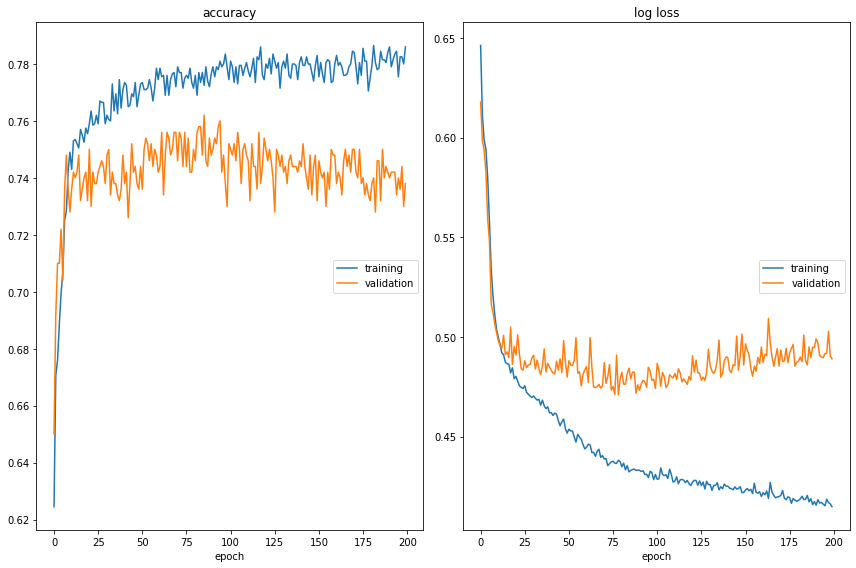

accuracy
	training         	 (min:    0.625, max:    0.786, cur:    0.786)
	validation       	 (min:    0.650, max:    0.762, cur:    0.738)
log loss
	training         	 (min:    0.415, max:    0.646, cur:    0.415)
	validation       	 (min:    0.471, max:    0.618, cur:    0.489)

Avg. Test Loss: 0.489  Avg. Test Accuracy: 0.738


In [642]:
set_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()


test_loss, test_accuracy = validate(model, criterion, test_loader)  
print("")
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())

In [644]:
# 训练集拟合程度
model.eval()
test_features = X_train
test_labels = Y_train
test_input_tensor = torch.from_numpy(test_features)
out_probs = model(test_input_tensor.float()).detach()
out_classes = F.log_softmax(out_probs, dim=1).max(1)[1].numpy()
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.7895


# Feature Importance

In [645]:
from captum.attr import FeaturePermutation, IntegratedGradients

# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(20,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xticks(rotation=15)
        plt.xlabel(axis_title, fontsize=15)
        plt.title(title)
        
        
# plt.xlabel("Feature", fontsize=15)
# plt.ylabel("Coefficient", fontsize=15)
# # plt.title("Coefficients in Model", fontsize=18)
# plt.xticks(rotation=15) # 倾斜70度
# plt.ylim(-1.8, 1.5)
# plt.show()

Average Feature Importances
hf_base_water_volume_sum :  -0.089
hf_number :  -0.158
depth_to_basement_avg :  -0.149
well_depth_avg :  -0.427
injection_under_basement_number :  0.016
injection_depth_avg :  -0.050
injection_vol_sum :  -0.092


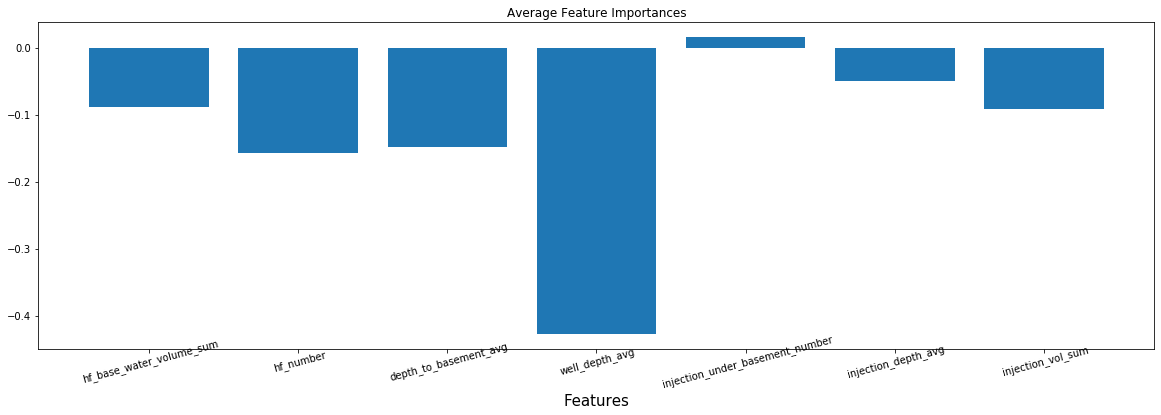

In [646]:
ig = IntegratedGradients(model)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor.float(),target=1, return_convergence_delta=True)
attr = attr.detach().numpy()
visualize_importances(feature_names, np.mean(attr, axis=0))

# Save the model

In [647]:
model.parameters()
path = "./model/EarthquakePredict_2010-2018_50*50_74ac.pt"
torch.save(model.state_dict,path)

# Test on all the dataset to reproduction

In [648]:
model.eval()
test_features = X
test_labels = Y

for i in range(0, feature_number):
    test_features[:,i] = (test_features[:,i] - mean_value[i]) / std_value[i]

test_input_tensor = torch.from_numpy(test_features)
out_probs = model(test_input_tensor.float()).detach()
out_classes = F.log_softmax(out_probs, dim=1).max(1)[1].numpy()
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.7792


Average Feature Importances
hf_base_water_volume_sum :  -0.089
hf_number :  -0.158
depth_to_basement_avg :  -0.137
well_depth_avg :  -0.447
injection_under_basement_number :  0.012
injection_depth_avg :  -0.052
injection_vol_sum :  -0.090


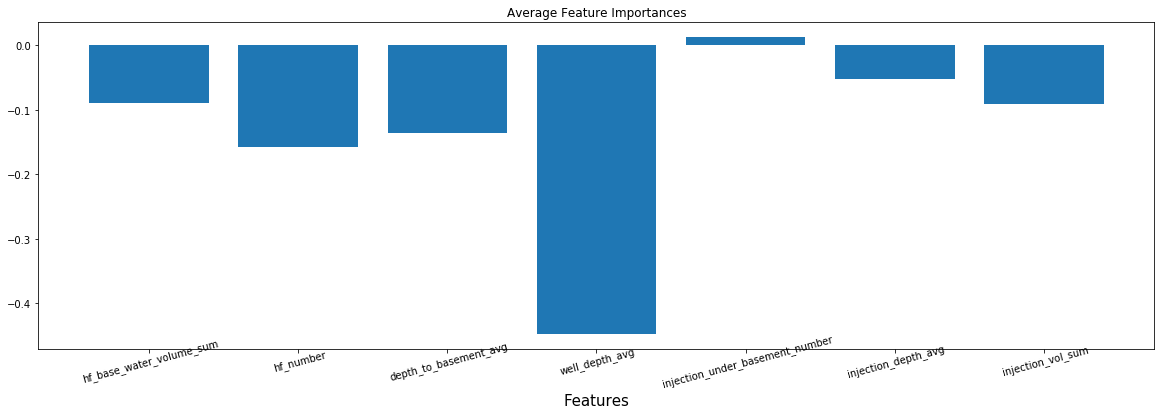

In [649]:
ig = IntegratedGradients(model)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor.float(),target=1, return_convergence_delta=True)
attr = attr.detach().numpy()
visualize_importances(feature_names, np.mean(attr, axis=0))

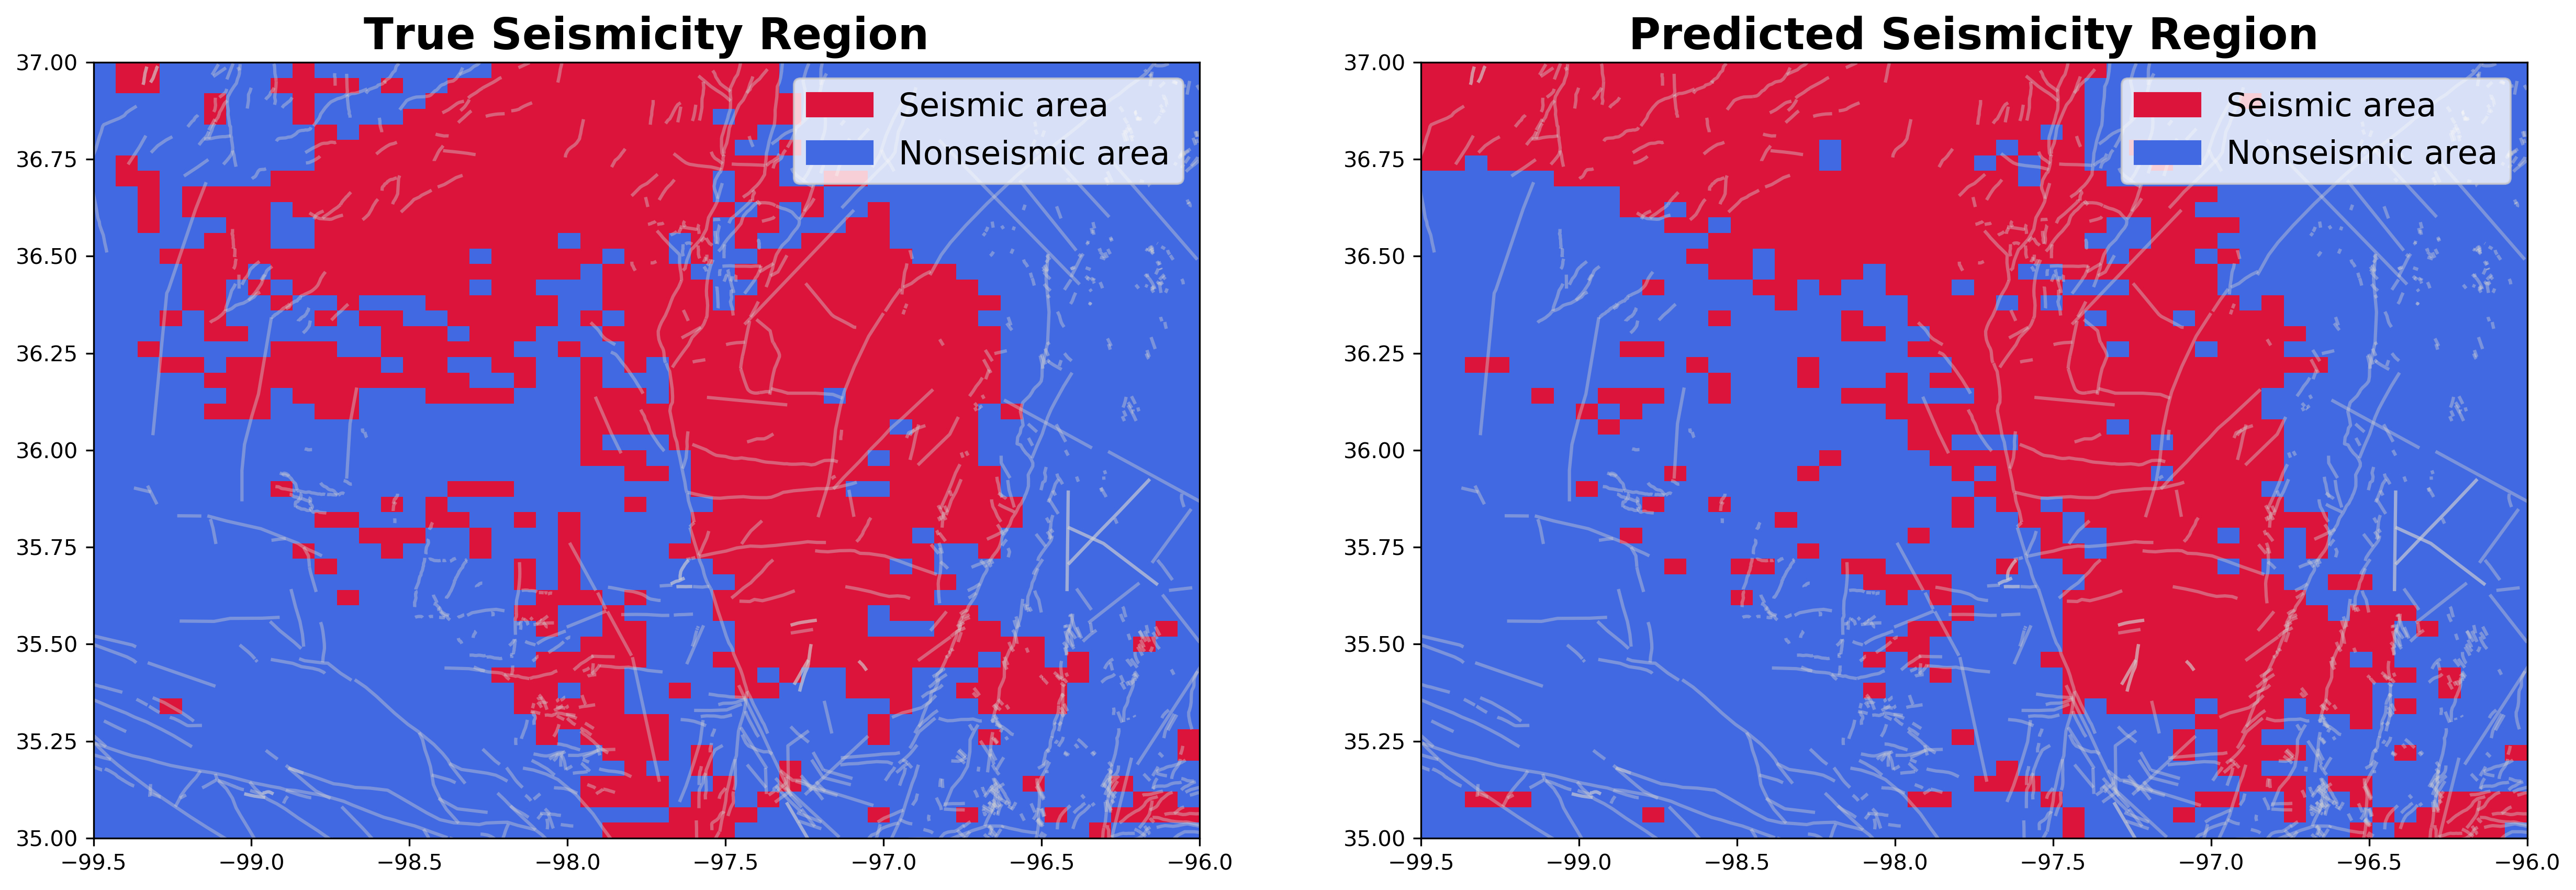

In [650]:
import matplotlib.patches as mpatches

m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1

x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='lightgrey')
oklahoma_map.plot(ax=ax2, alpha=0.4,color='lightgrey')

# 设置地图范围
lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x


plot_list = test_labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

plot_list = out_classes
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

ax1.set_xlim(-99.5, -96)
ax1.set_ylim(35, 37)
ax2.set_xlim(-99.5, -96)
ax2.set_ylim(35, 37)
ax1.set_title('True Seismicity Region', fontsize=20,fontweight='bold')
ax2.set_title('Predicted Seismicity Region', fontsize=20,fontweight='bold')


red_patch = mpatches.Patch(color='crimson', label='Seismic area')
blue_patch = mpatches.Patch(color='royalblue', label='Nonseismic area')
ax1.legend(handles=[red_patch, blue_patch], fontsize=15)
ax2.legend(handles=[red_patch, blue_patch], fontsize=15)
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()